<h3>Introduction to Style transferring</h3>

![Image of Yaktocat](https://photos5.appleinsider.com/gallery/20774-23042-photostyletransfer-xl.jpg)
Image source: appleinsider.com

- Neural style transfer (NST) is an optimization technique used to take two images; a content image and a style reference image (such as an artwork by a famous painter) and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

- Training a style transfer model requires two networks: a pre-trained feature extractor and a transfer network. An NST uses a pre-trained model trained on ImageNet or VGG. These try to minimize either the content loss (which help to establish similarities between the content image and the generated image) or style loss which is given by a Gram matrix which is a square matrix, with a width and height equal to the depth of the convolutional layer in question. 

<h3>The goal of this Kernel</h3>

- This body of work showcases a small chunk of code inspired by [Gatys et al. (2016)](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) and Udacity's "Intro to Deep Learning with PyTorch" which anyone can use to transform an image into a piece of art (no painting skills required!).

<h4>Step 1.1 - Import Modules</h4>

In [1]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

<h4>Step 1.2 - Load in the pre-trained VGG19 model (specifically its features)</h4>

VGG19 is split into two portions:
- vgg19.features which are all the convolutional and pooling layers
- vgg19.classifier which are the three linear, classifier layers at the end

We only need the features portion, which we're going to load in and "freeze" the weights of, below.

In [2]:
# Loading the model
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

<h4>Step 1.3 - Move the model to the Graphics Processing Unit (GPU) if one is available</h4>

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# if this results in "device(type='cuda')" then a GPU is indeed available
device

# Moving the model to the GPU
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

<h4>Step 1.4 - Load in the content and style images through a function</h4>

In [4]:
def load_image(img_path, max_size=400, shape=None):
    
    #Load in and transform an image, making sure the image is <= 400 pixels in the x-y dims.
    if 'http' in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
        
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([transforms.Resize(size),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), 
                                                            (0.229, 0.224, 0.225))])
    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image
       

# Loading the content image
content = load_image('photos\shan_shui_01.jpg').to(device)
# Loading the style image, resizing it to match the content image
style = load_image('photos\VG_01.png', shape=content.shape[-2:]).to(device)

<h4>Step 2 - Visualizing the images</h4>

Here, we are going to build a function for un-normalizing the images and converting them from a Tensor image to a NumPy image for display

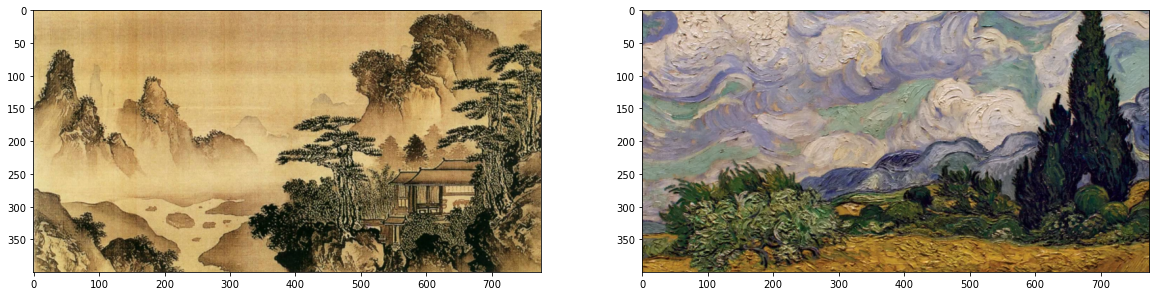

In [5]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

<h4>Step 3.1 - Selecting the content and style features </h4>

To get the content and style representations of an image, we have to pass an image forward through the VGG19 network until we get to the desired layer(s) and then get the output from that layer.

This is achieved as follows:

In [6]:
# Content and Style Features
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}
        
        
    ## -- do not need to change the code below this line -- ##
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

<h4> 3.2 Designing the Gram Matrix </h4>

As briefly touched upon earlier, a gram matrix is the result of multiplying a given matrix by its transposed matrix. In this application the given matrix is a reshaped version of the image feature maps.
XL of a layer LL.

In [7]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    b, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(b * d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

<h4> 3.3 Putting everything together </h4>

We'll extract our features from our images and calculate the gram matrices for each layer in our style representation.

In [8]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change it is a good idea to start off with the target as a copy of our *content* image then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

<h4> 4.1 Setting model loss and weights </h4>

 In this section, we will set the weights for each style layer. Remember that weighting earlier layers more will result in *larger* style artifacts. Also, notice that we are excluding `conv4_2` which is  our content representation.

In [9]:
# Model weights
style_weights = {'conv1_1': 1,
                 'conv2_1': 0.9,
                 'conv3_1': 0.6,
                 'conv4_1': 0.65,
                 'conv5_1': 0.7}

# you may choose to leave these as is
content_weight = 5 # alpha
style_weight = 1e4 # beta

<h4> 4.2 Updating the target and caclulating the losses </h4>

Total loss:  327.6990966796875


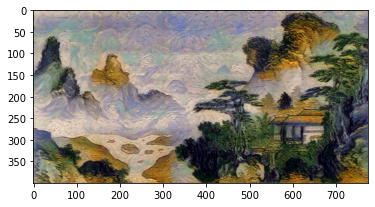

Total loss:  247.5624542236328


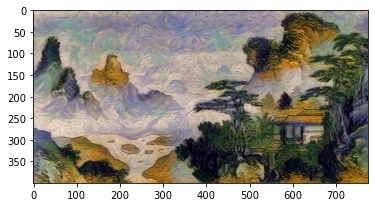

Total loss:  224.49188232421875


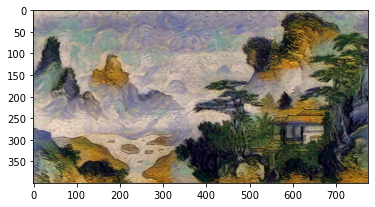

Total loss:  252.79165649414062


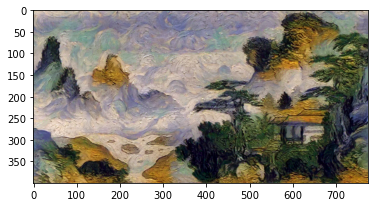

Total loss:  196.3856201171875


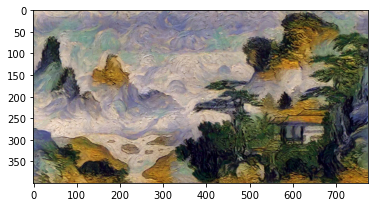

In [10]:
# for displaying the target image, intermittenly 
show_every = 8000

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.01)
steps = 40000 # decide how many iterations to update your image

for ii in range(1, steps+1):
    # get the features from your target image, then calculate the content loss
    target_features = get_features(target, vgg)
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # iterate through each style layer and add to the style loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        # Calculate the target gram matrix
        target_gram = gram_matrix(target_feature)
        # get the "Style" style representation
        style_gram = style_grams[layer]
        # Calculate the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
    # Calculate the total loss
    total_loss = (content_loss * content_weight) + (style_loss * style_weight)
    
    # update the target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

<h4> 4.3 Display the target image </h4>

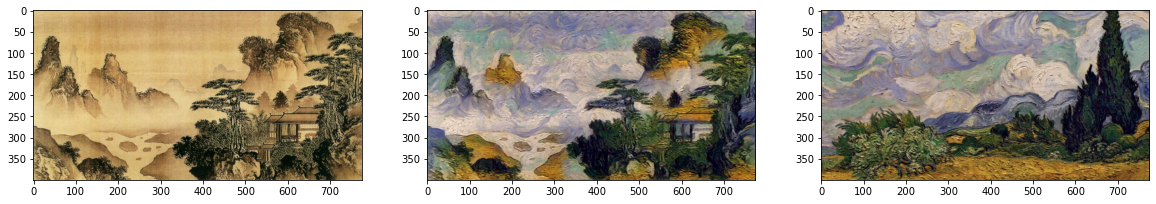

In [11]:
# display content and final, target image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))
ax3.imshow(im_convert(style))

<h4> Final remarks</h4>

- As we can see, this piece of code can successfully mix traditional Chinese (shan shui) and post-impressionism styles to create one remarkable piece of art.

- Feel free to mix and match any content image with any style of your preference, though if you choose to do so, make sure to update the hyperparameters (number of iterations, learning rate, model weights, etc.) in order to create a model suitable for your own needs.